## Path simulation using Quantum Computing

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

def load_and_clean_data(file_path):
        """Load and preprocess stock price data."""
        data = pd.read_csv(file_path, parse_dates=['Date'])
        for col in ['Price','Open', 'High', 'Low']:
            data[col] = data[col].str.replace(',', '').astype(float)
        data = data.sort_values('Date')
        return data

load_and_clean_data('StoxxLarger.csv')

Epoch 0: Loss = 0.059636


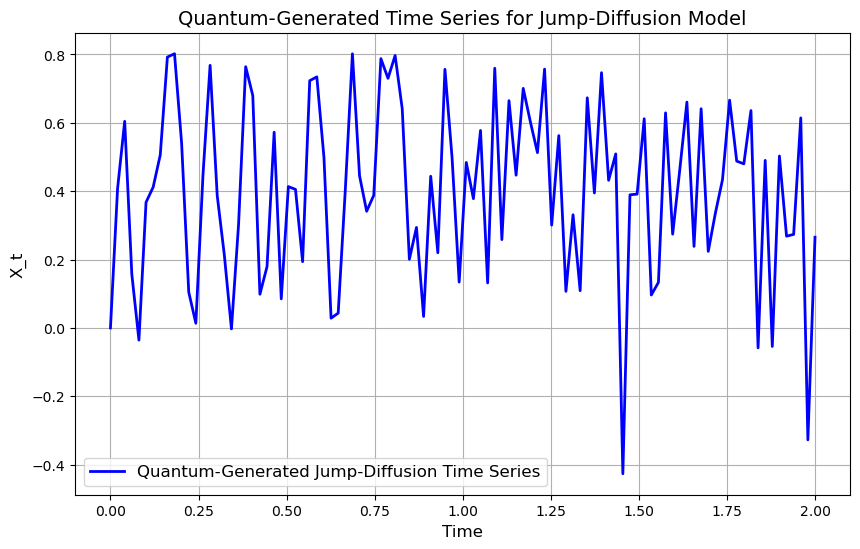

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson

# Quantum circuit parameters
n_qubits = 4
depth = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Merton Jump-Diffusion parameters
nu = 0.5        # Rate of reversion
mu = 0.4        # Long-term mean
sigma = 0.2     # Volatility
lambda_j = 0.3  # Jump intensity (average jumps per unit time)
mu_J = -0.02    # Mean jump size
sigma_J = 0.05  # Jump size volatility

# Define the quantile function for the Jump-Diffusion process
def jump_diffusion_quantile(z, t, nu=nu, mu=mu, sigma=sigma, lambda_j=lambda_j, mu_J=mu_J, sigma_J=sigma_J):
    """Quantile function for the Jump-Diffusion process."""
    variance = (sigma**2 / (2 * nu)) * (1 - np.exp(-2 * nu * t))
    mean = mu
    
    # Simulate Poisson-distributed jumps
    num_jumps = poisson.rvs(lambda_j * t)
    jump_sizes = np.sum(np.random.normal(mu_J, sigma_J, num_jumps)) if num_jumps > 0 else 0
    
    return mean + np.sqrt(variance) * norm.ppf(z) + jump_sizes

# Quantum circuit feature maps (Modified for Jump-Diffusion)
def feature_map_latent_variable(z):
    """Feature map to encode the latent variable z."""
    for i in range(n_qubits):
        qml.RX(np.pi * z, wires=i)

def feature_map_time(t, t_max=2.0):
    """Feature map to encode time t."""
    t_normalized = t / t_max
    t_clipped = np.clip(t_normalized, 0, 1)
    for i in range(n_qubits):
        qml.RY(np.arcsin(t_clipped), wires=i)

def feature_map_jumps(jump_count):
    """Feature map to encode jump occurrences."""
    for i in range(n_qubits):
        qml.RZ(jump_count * np.pi / 4, wires=i)  # Encode jumps as phase shifts

# Variational ansatz
def variational_ansatz(params):
    """Hardware-efficient ansatz with entangling CNOT gates."""
    for d in range(depth):
        for i in range(n_qubits):
            qml.Rot(*params[d, i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the quantum circuit (Modified for Jump-Diffusion)
@qml.qnode(dev)
def quantum_circuit(z, t, jump_count, params):
    """Quantum circuit representing the quantile function for Jump-Diffusion."""
    feature_map_latent_variable(z)
    feature_map_time(t)
    feature_map_jumps(jump_count)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))

# Loss function (Modified for Jump-Diffusion)
def loss(params, z_vals, t, jump_counts, targets):
    """Mean squared error loss."""
    preds = np.array([quantum_circuit(z, t, j, params) for z, j in zip(z_vals, jump_counts)])
    return np.mean((preds - targets) ** 2)

# Optimization setup
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 2  # Increased epochs for better training

# Generate training data (Modified for Jump-Diffusion)
t_vals = np.linspace(0.0, 2.0, 20)
z_vals = np.linspace(0.01, 0.99, 100)
training_data = []

for t in t_vals:
    jump_counts = poisson.rvs(lambda_j * t, size=len(z_vals))  # Generate jump counts
    targets = np.array([jump_diffusion_quantile(z, t) for z in z_vals])
    training_data.append((t, jump_counts, targets))

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(-np.pi, np.pi, (depth, n_qubits, 3))

# Training loop
for epoch in range(epochs):
    for t, jump_counts, targets in training_data:
        params = opt.step(lambda p: loss(p, z_vals, t, jump_counts, targets), params)
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss = {loss(params, z_vals, t, jump_counts, targets):.6f}")

# Generate Jump-Diffusion time-series using the learned quantum circuit
def generate_jump_diffusion_series(t_steps, params, initial_value=0.0):
    """Generate a Jump-Diffusion time-series using the learned quantum circuit."""
    X = [initial_value]
    for t in t_steps[1:]:
        z_t = np.random.uniform(0, 1)  # Sample latent variable
        jump_count = poisson.rvs(lambda_j * t)  # Generate jump count
        X_t = quantum_circuit(z_t, t, jump_count, params)  # Use learned model
        X.append(X_t)
    return np.array(X)

# Generate synthetic market data
t_steps = np.linspace(0, 2, 100)
jump_diffusion_series = generate_jump_diffusion_series(t_steps, params)

# Plot the time-series
plt.figure(figsize=(10, 6))
plt.plot(t_steps, jump_diffusion_series, label="Quantum-Generated Jump-Diffusion Time Series", color="blue", linewidth=2)
plt.title("Quantum-Generated Time Series for Jump-Diffusion Model", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("X_t", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/tmp/ipykernel_962/3710631156.py:14: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(z), wires=i)  # Encode `z` using Y-rotations
/tmp/ipykernel_962/3710631156.py:14: RuntimeWarning: invalid value encountered in arcsin
  qml.RY(np.arcsin(z), wires=i)  # Encode `z` using Y-rotations


Epoch 0: Loss = nan


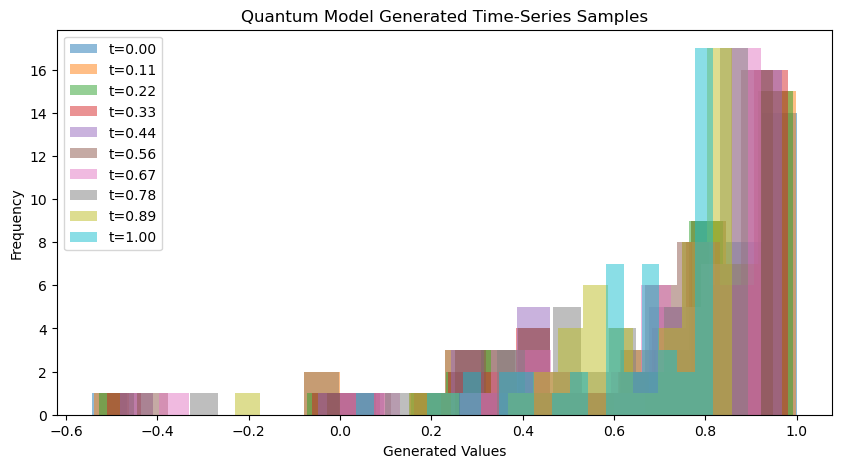

In [3]:
import pennylane as qml
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set Pennylane device: Using a quantum simulator with 4 qubits
n_qubits = 4  # Number of qubits
dev = qml.device("default.qubit", wires=n_qubits)

# 📌 STEP 1: Define the Quantum Circuit (Differentiable Quantum Circuit - DQC)
def quantum_feature_map(z, t):
    """Encodes the latent variable `z` and time `t` using rotation gates."""
    for i in range(n_qubits):
        qml.RY(np.arcsin(z), wires=i)  # Encode `z` using Y-rotations
        qml.RZ(np.arcsin(t), wires=i)  # Encode `t` using Z-rotations

def variational_ansatz(params):
    """Parameterized quantum circuit with entanglement (Hardware-Efficient Ansatz)."""
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)  # Trainable rotations

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])  # Entangling layer

@qml.qnode(dev, interface="autograd")
def quantum_circuit(z, t, params):
    """Full quantum circuit combining feature map and variational ansatz."""
    quantum_feature_map(z, t)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))  # Readout from qubit 0

# 📌 STEP 2: Generate Merton Jump Diffusion Model Data
def generate_merton_jump_diffusion(n_samples=1000, dt=0.01, mu=0.05, sigma=0.2, lam=0.5, mu_j=0.02, sigma_j=0.1):
    """
    Simulates the Merton Jump Diffusion model using the Euler-Maruyama method.
    Returns samples and the corresponding quantile function.
    """
    X = np.zeros(n_samples)
    for i in range(1, n_samples):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        dN = np.random.poisson(lam * dt)  # Poisson process for jumps
        J = np.sum(np.random.normal(mu_j, sigma_j, dN)) if dN > 0 else 0  # Jump component
        X[i] = X[i-1] + mu * dt + sigma * dW + J  # Merton Jump Diffusion SDE

    # Compute empirical CDF and its inverse (Quantile Function)
    cdf = stats.norm.cdf(X, np.mean(X), np.std(X))
    quantile_function = stats.norm.ppf(cdf)
    return X, quantile_function

# 📌 STEP 3: Load Real-World Data and Combine with Merton Jump Diffusion Model
def load_real_data():
    """Simulated real-world data (replace this with actual dataset loading)."""
    np.random.seed(42)
    return np.random.normal(loc=1.0, scale=0.2, size=1000)

# 📌 STEP 4: Define Loss Functions
def loss_data(params, z_samples, t, quantile_real):
    """Loss function for real-world data training."""
    predictions = np.array([quantum_circuit(z, t, params) for z in z_samples])
    return np.mean((predictions - quantile_real) ** 2)  # Mean Squared Error (MSE)

def loss_merton(params, z_samples, t, mu=0.05, sigma=0.2, lam=0.5, mu_j=0.02, sigma_j=0.1):
    """Loss function for enforcing the Merton Jump Diffusion process."""
    dQ_dt = np.array([(quantum_circuit(z, t + 0.01, params) - quantum_circuit(z, t, params)) / 0.01 for z in z_samples])
    d2Q_dz2 = np.array([(quantum_circuit(z + 0.01, t, params) - 2 * quantum_circuit(z, t, params) + quantum_circuit(z - 0.01, t, params)) / 0.01 ** 2 for z in z_samples])

    # Merton Jump Diffusion constraint
    sde_residual = dQ_dt - (mu * np.array([quantum_circuit(z, t, params) for z in z_samples]) + (sigma ** 2 / 2) * d2Q_dz2)
    return np.mean(sde_residual ** 2)  # Minimize deviation from MJD equation

# 📌 STEP 5: Define Weighted Loss and Optimization
def total_loss(params, z_samples, t, quantile_real, lambda_data=0.7, lambda_merton=0.3):
    """Total loss combining real data loss and Merton-based loss using weighted coefficients."""
    return lambda_data * loss_data(params, z_samples, t, quantile_real) + lambda_merton * loss_merton(params, z_samples, t)

# 📌 STEP 6: Training the Quantum Model
n_epochs = 1  # Number of training iterations
lr = 0.05  # Learning rate
opt = qml.AdamOptimizer(lr)  # PennyLane's gradient-based optimizer
params = np.random.rand(n_qubits)  # Initialize trainable parameters

# Load and preprocess data
real_data = load_real_data()
merton_samples, merton_quantiles = generate_merton_jump_diffusion()

# Select training points (subset)
z_samples = np.random.uniform(-1, 1, size=100)
quantile_real = np.interp(z_samples, np.linspace(-1, 1, len(real_data)), np.sort(real_data))

# Train loop
for epoch in range(n_epochs):
    params = opt.step(lambda p: total_loss(p, z_samples, 0.0, quantile_real), params)

    if epoch % 10 == 0:
        loss_value = total_loss(params, z_samples, 0.0, quantile_real)
        print(f"Epoch {epoch}: Loss = {loss_value:.6f}")

# 📌 STEP 7: Generate Future Time-Series Data from Trained Quantum Model
t_future = np.linspace(0, 1, 10)  # Future time steps
z_samples_future = np.random.uniform(-1, 1, size=50)

generated_samples = []
for t in t_future:
    generated_samples.append([quantum_circuit(z, t, params) for z in z_samples_future])

# Plot the generated samples
plt.figure(figsize=(10, 5))
for i, t in enumerate(t_future):
    plt.hist(generated_samples[i], bins=20, alpha=0.5, label=f"t={t:.2f}")

plt.legend()
plt.xlabel("Generated Values")
plt.ylabel("Frequency")
plt.title("Quantum Model Generated Time-Series Samples")
plt.show()


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 0: Loss = 0.372758


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

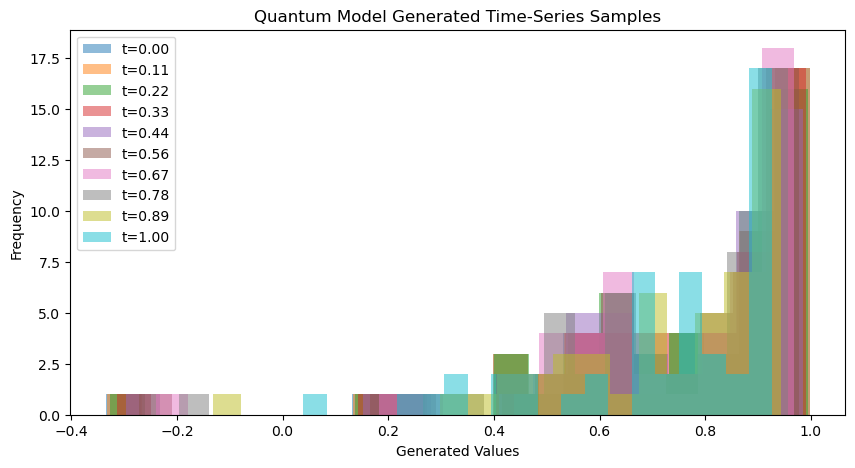

In [17]:
import pennylane as qml
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set PennyLane device: Using a quantum simulator with 4 qubits
n_qubits = 4  # Number of qubits
dev = qml.device("default.qubit", wires=n_qubits)


def quantum_feature_map(z, t):
    """Encodes the latent variable `z` and time `t` using rotation gates, ensuring valid input range."""
    z = np.clip(z, -1, 1)  # Clip z to ensure it is within arcsin's domain
    t = np.clip(t, -1, 1)  # Clip t to ensure it is within arcsin's domain

    for i in range(n_qubits):
        qml.RY(np.arcsin(z), wires=i)  # Encode `z` using Y-rotations
        qml.RZ(np.arcsin(t), wires=i)  # Encode `t` using Z-rotations


def variational_ansatz(params):
    """Parameterized quantum circuit with entanglement."""
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)  # Trainable rotations
        qml.RZ(params[i + n_qubits], wires=i)  # Additional tunable rotations

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])  # Entangling layer (CNOT gates)

@qml.qnode(dev, interface="autograd")
def quantum_circuit(z, t, params):
    """Full quantum circuit combining feature map and variational ansatz."""
    quantum_feature_map(z, t)
    variational_ansatz(params)
    return qml.expval(qml.PauliZ(0))  # Readout from qubit 0


def generate_merton_jump_diffusion(n_samples=1000, dt=0.01, mu=0.05, sigma=0.2, lam=0.5, mu_j=0.02, sigma_j=0.1):
    """Simulates the Merton Jump Diffusion model using the Euler-Maruyama method."""
    X = np.zeros(n_samples)
    for i in range(1, n_samples):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        dN = np.random.poisson(lam * dt)  # Poisson process for jumps
        J = np.sum(np.random.normal(mu_j, sigma_j, dN)) if dN > 0 else 0  # Jump component
        X[i] = X[i-1] + mu * dt + sigma * dW + J

    # Compute empirical CDF and its inverse (Quantile Function)
    cdf = stats.norm.cdf(X, np.mean(X), np.std(X))
    quantile_function = stats.norm.ppf(cdf)
    return X, quantile_function


def load_real_data():
    """Simulated real-world data (replace this with actual dataset loading)."""
    np.random.seed(42)
    return np.random.normal(loc=1.0, scale=0.2, size=1000)


def loss_data(params, z_samples, t, quantile_real):
    """Loss function for real-world data training."""
    predictions = np.array([quantum_circuit(z, t, params) for z in z_samples])
    return np.mean((predictions - quantile_real) ** 2)  # Mean Squared Error (MSE)

def loss_merton(params, z_samples, t, mu=0.05, sigma=0.2, lam=0.5, mu_j=0.02, sigma_j=0.1):
    """Loss function for enforcing the Merton Jump Diffusion process."""
    dQ_dt = np.array([(quantum_circuit(z, t + 0.01, params) - quantum_circuit(z, t, params)) / 0.01 for z in z_samples])
    d2Q_dz2 = np.array([(quantum_circuit(z + 0.01, t, params) - 2 * quantum_circuit(z, t, params) + quantum_circuit(z - 0.01, t, params)) / 0.01 ** 2 for z in z_samples])

    sde_residual = dQ_dt - (mu * np.array([quantum_circuit(z, t, params) for z in z_samples]) + (sigma ** 2 / 2) * d2Q_dz2)
    return np.mean(sde_residual ** 2)  # Minimize deviation from MJD equation

def total_loss(params, z_samples, t, quantile_real, lambda_data=0.7, lambda_merton=0.3):
    """Total loss combining real data loss and Merton-based loss using weighted coefficients."""
    return lambda_data * loss_data(params, z_samples, t, quantile_real) + lambda_merton * loss_merton(params, z_samples, t)


n_epochs = 5  # Number of training iterations
lr = 0.05  # Learning rate
opt = qml.AdamOptimizer(lr)  # PennyLane's gradient-based optimizer
params = np.random.rand(2 * n_qubits)  # Initialize trainable parameters

# Load and preprocess data
real_data = load_real_data()
merton_samples, merton_quantiles = generate_merton_jump_diffusion()

# Select training points (subset)
z_samples = np.random.uniform(-1, 1, size=100)
quantile_real = np.interp(z_samples, np.linspace(-1, 1, len(real_data)), np.sort(real_data))

# Train loop
for epoch in range(n_epochs):
    params = opt.step(lambda p: total_loss(p, z_samples, 0.0, quantile_real), params)

    if epoch % 10 == 0:
        loss_value = total_loss(params, z_samples, 0.0, quantile_real)
        print(f"Epoch {epoch}: Loss = {loss_value:.6f}")


t_future = np.linspace(0, 1, 10)  # Future time steps
z_samples_future = np.random.uniform(-1, 1, size=50)

generated_samples = []
for t in t_future:
    generated_samples.append([quantum_circuit(z, t, params) for z in z_samples_future])

# Plot the generated samples
plt.figure(figsize=(10, 5))
for i, t in enumerate(t_future):
    plt.hist(generated_samples[i], bins=20, alpha=0.5, label=f"t={t:.2f}")

plt.legend()
plt.xlabel("Generated Values")
plt.ylabel("Frequency")
plt.title("Quantum Model Generated Time-Series Samples")
plt.show()


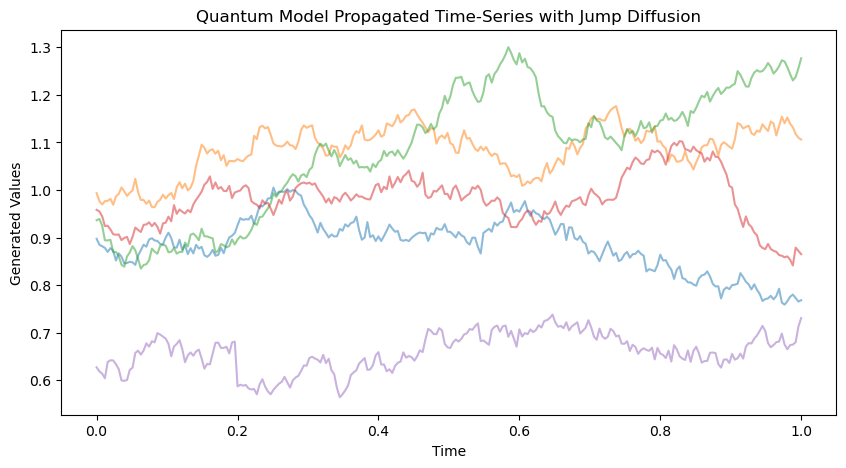

In [22]:
import numpy as np
import matplotlib.pyplot as plt


t_min, t_max = 0, 1  # Time range
n_steps = 256  # Number of time steps
dt = (t_max - t_min) / n_steps  # Time step size
t_values = np.linspace(t_min, t_max, n_steps)  # Time grid

# Parameters for the Jump Diffusion Model
mu = 0.05       # Drift
sigma = 0.2     # Volatility
lam = 0.5       # Poisson jump intensity
mu_j = 0.02     # Jump mean
sigma_j = 0.1   # Jump std deviation

# Initialize the time-series at t=0
n_samples = 5  # Number of sample paths
X_paths = np.zeros((n_samples, n_steps))

# Sample initial values using the trained quantum model at t=0
z_samples = np.random.uniform(-1, 1, size=n_samples)
X_paths[:, 0] = np.array([quantum_circuit(z, 0, params) for z in z_samples])

for t_idx in range(1, n_steps):
    t = t_values[t_idx]  # Current time step

    for i in range(n_samples):
        z = np.random.uniform(-1, 1)  # Sample latent variable

        # Compute the learned quantile function value using the quantum model
        Q_t = quantum_circuit(z, t, params)

        # Brownian motion increment
        dW = np.random.normal(0, np.sqrt(dt))

        # Poisson jump process
        dN = np.random.poisson(lam * dt)
        J = np.sum(np.random.normal(mu_j, sigma_j, dN)) if dN > 0 else 0

        # Introduce a sine-like deterministic trend
        #sine_drift = 0.1 * np.sin(2 * np.pi * t)

    
        X_paths[i, t_idx] = X_paths[i, t_idx - 1] + mu * dt + sigma * dW + J #+ sine_drift


plt.figure(figsize=(10, 5))

for i in range(n_samples):
    plt.plot(t_values, X_paths[i, :], alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Generated Values")
plt.title("Quantum Model Propagated Time-Series with Jump Diffusion")
plt.show()


In [14]:
import pennylane as qml
import numpy as np
import pandas as pd
from pennylane import numpy as pnp
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

def load_stock_data(filename):
    df = pd.read_csv(filename, thousands=',', dtype={'Price': str})  # Ensure "Price" is read as a string
    df = df[['Date', 'Price']].dropna()
    df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)  # Convert to float after cleaning
    df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(-1))
    df = df.dropna()
    return df['Log_Return'].values, df['Price'].values[-1]  # Return last actual price for reconstruction


# Discretize using Symbolic Aggregate Approximation (SAX)
def discretize_series(series, num_bins=4):
    series = series.reshape(-1, 1)  # Ensure correct shape for scaler
    scaler = MinMaxScaler(feature_range=(0, num_bins - 1))
    discrete_series = np.round(scaler.fit_transform(series).flatten()).astype(int)
    return discrete_series, scaler


# Define the QCBM model
num_qubits = 4
num_layers = 3

dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def quantum_model(params):
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    
    for l in range(num_layers):
        for i in range(num_qubits):
            qml.RY(params[l, i], wires=i)
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    
    return [qml.probs(wires=i) for i in range(num_qubits)]

# Training with KL divergence loss
def kl_divergence(p, q):
    return entropy(p, q)

def train_qcbm(stock_data, epochs=100, lr=0.1):
    discrete_data, scaler = discretize_series(stock_data)
    target_distribution, _ = np.histogram(discrete_data, bins=num_qubits, density=True)
    target_distribution = target_distribution / np.sum(target_distribution)  # Ensure normalization
    
    params = pnp.random.uniform(0, np.pi, (num_layers, num_qubits), requires_grad=True)
    opt = qml.AdamOptimizer(lr)
    
    for epoch in range(epochs):
        def cost(params):
            generated_distribution = np.concatenate(quantum_model(params)).flatten()
            return kl_divergence(target_distribution, generated_distribution)
        
        params = opt.step(cost, params)
        
        if epoch % 10 == 0:
            loss = cost(params)
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
    
    return params, scaler


# Generate synthetic stock prices
def generate_synthetic_prices(params, scaler, last_price, steps=10):
    generated_distribution = np.array(quantum_model(params)).flatten()
    sampled_indices = np.random.choice(range(len(generated_distribution)), size=steps, p=generated_distribution)
    generated_log_returns = scaler.inverse_transform(sampled_indices.reshape(-1, 1)).flatten()
    
    synthetic_prices = [last_price]
    for log_return in generated_log_returns:
        synthetic_prices.append(synthetic_prices[-1] * np.exp(log_return))
    
    return synthetic_prices[1:]

# Main execution
if __name__ == "__main__":
    stock_returns, last_price = load_stock_data("StoxxLarger.csv")
    trained_params, scaler = train_qcbm(stock_returns)
    
    synthetic_prices = generate_synthetic_prices(trained_params, scaler, last_price, steps=10)
    print("Generated Synthetic Prices:", synthetic_prices)
    print("Training complete. Generated model ready.")


ValueError: Array shapes are incompatible for broadcasting.

In [ ]:
def load_stock_data(filename):
    df = pd.read_csv(filename, thousands=',', dtype={'Price': str})  # Ensure "Price" is read as a string
    df = df[['Date', 'Price']].dropna()
    df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)  # Convert to float after cleaning
    df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(-1))
    df = df.dropna()
    return df['Log_Return'].values, df['Price'].values[-1]  # Return last actual price for reconstruction

In [15]:
load_stock_data("StoxxLarger.csv")

(array([ 0.00047911,  0.00209545,  0.0076882 , ...,  0.00313541,
         0.01766511, -0.00465115]),
 3547.85)

/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 0: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 10: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 20: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 30: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 40: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 50: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 60: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 70: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 80: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

Epoch 90: Loss = 0.368779


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable par

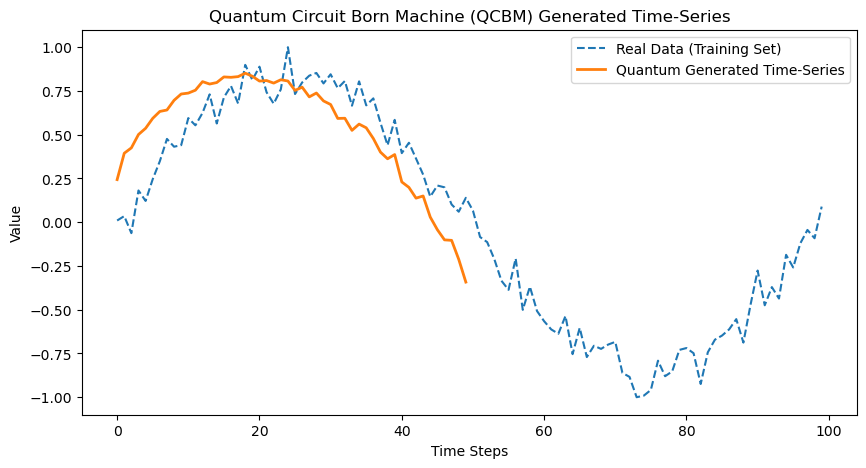

In [25]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# 📌 STEP 1: Set Up Quantum Device
n_qubits = 4  # Number of qubits to encode states
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

# 📌 STEP 2: Define the Quantum Circuit
@qml.qnode(dev)
def quantum_circuit(params, z):
    """
    Quantum Circuit Born Machine (QCBM) to generate time-series samples.
    Encodes a latent variable `z` and applies a parameterized unitary `U(theta)`.
    """
    
    # Encoding latent variable `z`
    for i in range(n_qubits):
        qml.RY(np.arcsin(z), wires=i)  # Encode latent variable into qubits
    
    # Variational quantum layer (trainable ansatz)
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
        qml.RZ(params[n_qubits + i], wires=i)
    
    # Entanglement layer (introducing correlations)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    
    # Measurement to obtain output probability distribution
    return qml.probs(wires=range(n_qubits))

# 📌 STEP 3: Initialize Training Data
def generate_training_data(n_samples=100):
    """
    Simulates synthetic time-series data for training.
    The data is normalized between -1 and 1 for quantum encoding.
    """
    time_series = np.sin(np.linspace(0, 2 * np.pi, n_samples))  # Sine wave pattern
    time_series += np.random.normal(scale=0.1, size=n_samples)  # Adding noise
    return (time_series - np.min(time_series)) / (np.max(time_series) - np.min(time_series)) * 2 - 1  # Normalize to [-1,1]

# Generate training data
real_data = generate_training_data()

# 📌 STEP 4: Define the Cost Function
def loss(params):
    """
    Computes the loss function by comparing quantum-generated samples with real data.
    """
    sampled_z = np.random.uniform(-1, 1, size=len(real_data))  # Sample latent variables
    quantum_outputs = np.array([quantum_circuit(params, z) for z in sampled_z])  # Quantum circuit output
    
    # Convert quantum probabilities to classical values
    generated_data = np.mean(quantum_outputs, axis=1)
    
    # Mean Squared Error (MSE) loss
    return np.mean((generated_data - real_data) ** 2)

# 📌 STEP 5: Train the Quantum Circuit
n_epochs = 100  # Training iterations
lr = 0.1  # Learning rate
params = np.random.uniform(-np.pi, np.pi, size=2 * n_qubits)  # Random parameter initialization

opt = qml.AdamOptimizer(lr)

# Training loop
loss_history = []
for epoch in range(n_epochs):
    params = opt.step(loss, params)  # Gradient-based optimization
    current_loss = loss(params)
    loss_history.append(current_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {current_loss:.6f}")




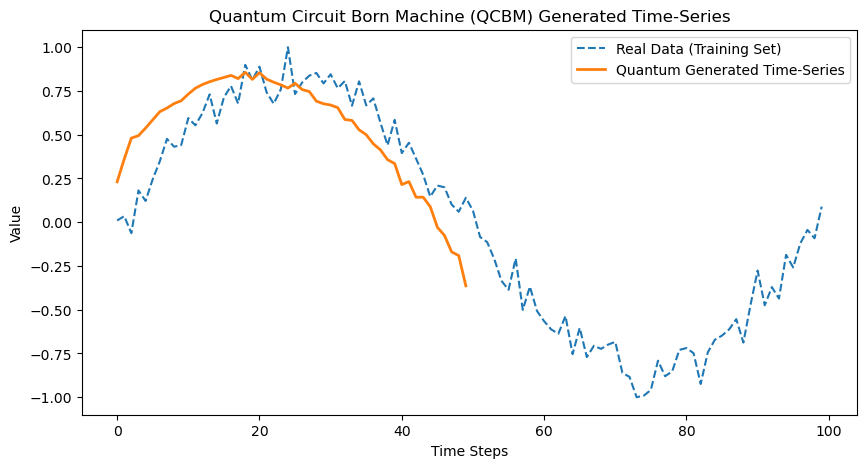

In [30]:
# 📌 STEP 6: Generate a New Time-Series Using the Trained Quantum Model
def generate_quantum_time_series(params, n_steps=50):
    """
    Uses the trained quantum model to generate a new time-series.
    """
    generated_series = []
    z_values = np.linspace(-1, 1, n_steps)  # Uniformly sample latent variable
    
    for z in z_values:
        output_probs = quantum_circuit(params, z)
        generated_value = np.dot(output_probs, np.linspace(-1, 1, 2 ** n_qubits))  # Weighted sum
        generated_series.append(generated_value)
    
    return generated_series

# Generate new quantum time-series
quantum_generated_series = generate_quantum_time_series(params)

# 📌 STEP 7: Visualize Results
plt.figure(figsize=(10, 5))
plt.plot(real_data, label="Real Data (Training Set)", linestyle="dashed")
plt.plot(quantum_generated_series, label="Quantum Generated Time-Series", linewidth=2)
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Quantum Circuit Born Machine (QCBM) Generated Time-Series")
plt.show()

In [103]:
import pandas as pd
import numpy as np
import pennylane as qml

# 📌 Load the dataset
file_path = "StoxxLarger.csv"
df = pd.read_csv(file_path)

# Convert 'Price' column to float (handle commas if necessary)
df["Price"] = df["Price"].astype(str).str.replace(",", "").astype(float)

# Reverse order (oldest date first)
df = df[::-1].reset_index(drop=True)

# Compute log returns (stationary time-series transformation)
df["Log_Return"] = np.log(df["Price"]).diff()

# Drop NaN from the first row
df.dropna(inplace=True)

# Discretize log returns into quantum states
num_states = 32 # Number of quantum states
df["State"] = np.digitize(df["Log_Return"], np.linspace(df["Log_Return"].min(), df["Log_Return"].max(), num_states))

print(df[["Date", "Price", "Log_Return", "State"]].head())  # Check preprocessed data


         Date    Price  Log_Return  State
1  01/05/2021  3547.85   -0.004651     12
2  01/06/2021  3611.08    0.017665     18
3  01/07/2021  3622.42    0.003135     14
4  01/08/2021  3645.05    0.006228     15
5  01/11/2021  3620.62   -0.006725     12


In [104]:
# Initialize transition matrix
transition_matrix = np.zeros((num_states, num_states))

# Count transitions between states
for i in range(len(df) - 1):
    from_state = df["State"].iloc[i]
    to_state = df["State"].iloc[i + 1]
    transition_matrix[from_state - 1, to_state - 1] += 1

# Normalize rows to create probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.nan_to_num(transition_matrix, nan=1.0 / num_states)

print("Transition Matrix:\n", transition_matrix)


Transition Matrix:
 [[0.      0.      0.      ... 0.      0.      0.     ]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.      0.      0.      ... 0.      0.      0.     ]
 ...
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.03125 0.03125 0.03125 ... 0.03125 0.03125 0.03125]
 [0.      0.      0.      ... 0.      0.      0.     ]]


/tmp/ipykernel_962/3094075901.py:11: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


In [105]:
# 📌 Define PennyLane QCBM Model
n_qubits = int(np.log2(num_states))  # Number of qubits needed
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_feature_map(state):
    """Encodes the state index into quantum rotations."""
    for i in range(n_qubits):
        qml.RY(np.pi * ((state >> i) & 1), wires=i)  # Binary encoding

def variational_ansatz(params):
    """Multi-layer variational circuit to increase expressiveness."""
    num_layers = 7  # Increase depth
    for _ in range(num_layers):
        for i in range(n_qubits):
            qml.RY(params[i], wires=i)
            qml.RZ(params[i + n_qubits], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])  # More entanglement


@qml.qnode(dev, interface="autograd")
def quantum_circuit(state, params):
    """Full quantum circuit with encoding and variational layers."""
    quantum_feature_map(state)
    variational_ansatz(params)
    return qml.probs(wires=range(n_qubits))  # Ensure full probability output



In [106]:
# Initialize parameters randomly
params = np.random.uniform(-np.pi, np.pi, size=2 * n_qubits)

def loss_function(params):
    """Computes the loss as the KL divergence between the quantum and empirical transition matrix."""
    loss = 0
    for i in range(num_states):
        q_probs = quantum_circuit(i, params)
        empirical_probs = transition_matrix[i]
        loss += np.sum(empirical_probs * np.log(empirical_probs / q_probs))  # KL divergence
    return loss

# Use PennyLane's gradient-based optimizer
optimizer = qml.AdamOptimizer(stepsize=0.1)
epochs = 100

# Training loop
for epoch in range(epochs):
    params = optimizer.step(loss_function, params)
    if epoch % 10 == 0:
        loss = loss_function(params)
        print(f"Epoch {epoch}: Loss = {loss:.6f}")

print("Optimized Parameters:", params)


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:158: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encounte

Epoch 0: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 10: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 20: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 30: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 40: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 50: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 60: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 70: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 80: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Epoch 90: Loss = nan


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/s

Optimized Parameters: [ 1.85570116 -2.07199624  0.08798993  0.62763066  2.91606603  1.99218748
 -0.69337535 -2.7791527   1.85660193 -0.5313528 ]


/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in log
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/sohamd/anaconda3/lib/python3.12/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


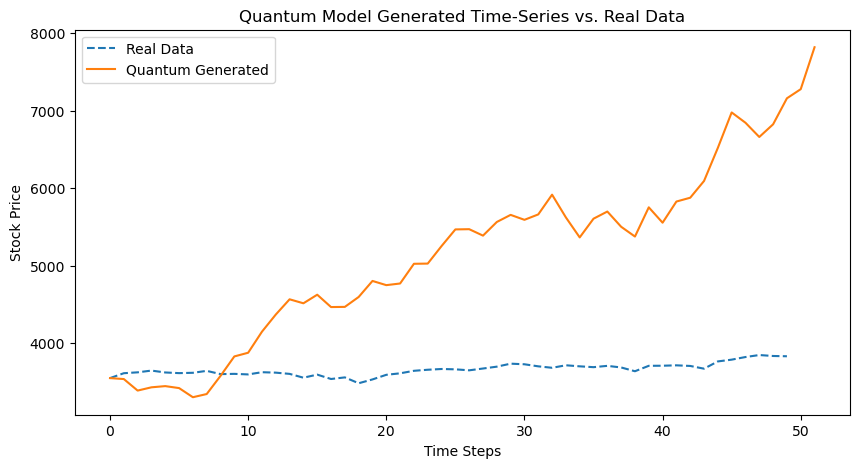

In [107]:
import matplotlib.pyplot as plt

# Simulate quantum-generated time-series
n_steps = 50  # Number of time steps to simulate
generated_states = [df["State"].iloc[0]]  # Start with the first real state

for _ in range(n_steps):
    q_probs = quantum_circuit(generated_states[-1], params)
    next_state = np.random.choice(num_states, p=q_probs)
    generated_states.append(next_state)

# Convert back to log returns
generated_log_returns = np.interp(generated_states, np.arange(num_states), np.linspace(df["Log_Return"].min(), df["Log_Return"].max(), num_states))

# Reconstruct price series from log returns
generated_prices = [df["Price"].iloc[0]]
for r in generated_log_returns:
    generated_prices.append(generated_prices[-1] * np.exp(r))

# 📌 Plot the results
plt.figure(figsize=(10, 5))
plt.plot(df["Price"].iloc[:n_steps].values, label="Real Data", linestyle="dashed")
plt.plot(generated_prices, label="Quantum Generated", linestyle="solid")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Quantum Model Generated Time-Series vs. Real Data")
plt.show()


## Tests from qcbmbased


In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---- Parameters ----
num_qubits = 4  # Number of qubits (discretization level 2^num_qubits)
layers = 3      # Number of layers in the variational circuit
shots = 1000    # Number of measurement samples

# Jump Diffusion Model Parameters
T = 1.0         # Time horizon
dt = 0.01       # Time step
S0 = 100        # Initial price
mu = 0.05       # Drift
sigma = 0.2     # Volatility
lambda_j = 0.5  # Poisson jump intensity
mu_J = -0.02    # Mean jump
sigma_J = 0.1   # Std of jump

# Create a quantum device
dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

# ---- Define Variational Circuit ----
def variational_circuit(params):
    """QCBM variational quantum circuit."""
    for i in range(num_qubits):
        qml.RY(params[i], wires=i)  # Rotation gates
        
    for l in range(layers):
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])  # Entanglement
        for i in range(num_qubits):
            qml.RZ(params[num_qubits + l * num_qubits + i], wires=i)

    return qml.probs(wires=range(num_qubits))

# ---- Define Quantum Model ----
@qml.qnode(dev)
def quantum_model(params):
    return variational_circuit(params)

# ---- Generate Training Data (Jump Diffusion Returns) ----
def simulate_jump_diffusion():
    """Simulates a Jump Diffusion process and discretizes returns."""
    N = int(T / dt)
    returns = []

    for _ in range(500):  # Generate 500 paths
        S = S0
        for _ in range(N):
            Z = np.random.normal(0, 1)  # Brownian motion
            N_jumps = np.random.poisson(lambda_j * dt)  # Poisson jumps
            J = np.sum(np.random.normal(mu_J, sigma_J, N_jumps)) if N_jumps > 0 else 0
            S *= np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) * (1 + J)
        
        returns.append(np.log(S / S0))  # Log return

    # Discretize returns into 2^num_qubits bins
    bins = np.linspace(min(returns), max(returns), 2**num_qubits)
    return np.digitize(returns, bins) - 1, bins  # Return binned states

# Generate training data
training_data, bins = simulate_jump_diffusion()

# ---- Define Cost Function (KL Divergence) ----
def kl_divergence(p, q):
    """Compute KL divergence between two probability distributions."""
    p = np.where(p == 0, 1e-10, p)  # Avoid log(0)
    q = np.where(q == 0, 1e-10, q)
    return np.sum(p * np.log(p / q))

def cost(params):
    """Computes the loss between quantum-generated and empirical distribution."""
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

# ---- Train QCBM ----
opt = qml.AdamOptimizer(stepsize=0.1)
params = np.random.uniform(0, np.pi, num_qubits + layers * num_qubits)  # Initialize random params
steps = 1000

for i in range(steps):
    params = opt.step(cost, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost(params)}")

# ---- Generate Synthetic Returns from Quantum Model ----
def generate_synthetic_returns(params, bins):
    """Samples from the trained quantum circuit to generate synthetic jump diffusion paths."""
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=500)
    synthetic_returns = bins[sampled_indices]
    return synthetic_returns

# Generate synthetic returns
synthetic_returns = generate_synthetic_returns(params, bins)

# ---- Plot Results ----
plt.figure(figsize=(10,5))
plt.hist(np.log(S0) + synthetic_returns, bins=30, alpha=0.7, label="Quantum Generated")
plt.hist(np.log(S0) + np.array(training_data), bins=30, alpha=0.5, label="Original Data")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.legend()
plt.title("Quantum-Generated vs. Real Jump Diffusion Returns")
plt.show()


In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Updated QCBM Parameters
num_qubits = 6  # Increased number of qubits
layers = 6       # Increased circuit depth
shots = 2000     # More measurement shots
dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

# Define a Deeper and More Expressive Variational Circuit
def variational_circuit(params):
    """Larger QCBM with more qubits, layers, and entanglement."""
    for i in range(num_qubits):
        qml.RY(params[i], wires=i)  # Initial rotations
        
    for l in range(layers):
        for i in range(num_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  # Nearest-neighbor entanglement
        for i in range(num_qubits):  
            qml.RZ(params[num_qubits + l * num_qubits + i], wires=i)  # More expressive rotations

    return qml.probs(wires=range(num_qubits))

# Define the Quantum Model
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return variational_circuit(params)

# Jump Diffusion Model Parameters
T = 1.0         
dt = 0.01       
steps = 100     
S0 = 100        
mu = 0.05       
sigma = 0.2     
lambda_j = 0.5  
mu_J = -0.02    
sigma_J = 0.1   

# Simulate Jump Diffusion and Bin Returns
def simulate_jump_diffusion():
    """Generates a set of jump diffusion returns and discretizes them into bins."""
    N = int(T / dt)
    returns = []
    for _ in range(1000):  # More training samples
        S = S0
        for _ in range(N):
            Z = np.random.normal(0, 1)  
            N_jumps = np.random.poisson(lambda_j * dt)  
            J = np.sum(np.random.normal(mu_J, sigma_J, N_jumps)) if N_jumps > 0 else 0
            S *= np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) * (1 + J)
        returns.append(np.log(S / S0))  
    bins = np.linspace(min(returns), max(returns), 2**num_qubits)
    return np.digitize(returns, bins) - 1, bins  

# Generate training data
training_data, bins = simulate_jump_diffusion()

# Cost Function
def kl_divergence(p, q):
    """Compute KL divergence between two probability distributions."""
    p = np.where(p == 0, 1e-10, p)  
    q = np.where(q == 0, 1e-10, q)
    return np.sum(p * np.log(p / q))

def cost(params):
    """Computes the loss between quantum-generated and empirical distribution."""
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

# Train QCBM with More Steps
opt = qml.AdamOptimizer(stepsize=0.05)  
params = np.random.uniform(0, np.pi, num_qubits + layers * num_qubits)  
steps_training = 300  # Increased training steps

for i in range(steps_training):
    params = opt.step(cost, params)
    if i % 50 == 0:
        print(f"Step {i}: Cost = {cost(params)}")

# Generate Synthetic Log Returns
def generate_synthetic_returns(params, bins, steps=100):
    """Generates a 100-step synthetic price path using the trained quantum model."""
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]

# Simulate a Stochastic Price Path
def simulate_stochastic_path(params, bins, steps=100):
    """Simulates a single stock price path using quantum-generated returns."""
    log_returns = generate_synthetic_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = S0  
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])  
    return S

# Generate Path
stochastic_path = simulate_stochastic_path(params, bins, steps)

# Plot Path
plt.figure(figsize=(10,5))
plt.plot(range(steps), stochastic_path, marker='o', linestyle='-', color='b')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Quantum-Generated Stochastic Path (Improved QCBM)')
plt.grid()
plt.show()


In [ ]:
import pennylane as qml
import pennylane.numpy as pnp  # Use PennyLane's NumPy for autodiff
import numpy as np
import matplotlib.pyplot as plt

# Quantum Parameters
num_qubits = 8  # System qubits (H_s)
env_qubits = 4   # Environment qubits (H_e)
total_qubits = num_qubits + env_qubits  # Full system size
layers = 7       # Ansatz layers
shots = 2000     # Quantum measurements

# Quantum Device
dev = qml.device("default.qubit", wires=total_qubits, shots=shots)

# ---- Hamiltonian Learning Ansatz ----
def variational_circuit(params):
    """Parameterized Quantum Circuit (Strongly Entangling Layer + Diagonal Evolution)."""
    for i in range(total_qubits):
        qml.RY(params[i], wires=i)  # Rotation Encoding
    
    # Strongly entangling layers
    for l in range(layers):
        for i in range(total_qubits - 1):
            qml.CNOT(wires=[i, i + 1])  # System-system & system-environment entanglement
        for i in range(total_qubits):
            qml.RZ(params[num_qubits + l * total_qubits + i], wires=i)  # Parameterized Z rotations

    # Simulating a diagonal unitary evolution
    for i in range(total_qubits):
        qml.RZ(params[-total_qubits + i], wires=i)  # Diagonal time evolution

    return qml.probs(wires=range(num_qubits))  # Measure system qubits

# Quantum Model Definition
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return variational_circuit(params)

# ---- Simulating the Jump Diffusion Model ----
def simulate_jump_diffusion():
    """Generates a Jump Diffusion time series and discretizes returns."""
    T = 1.0         
    dt = 0.01       
    steps = int(T / dt)
    S0 = 100        
    mu = 0.05       
    sigma = 0.2     
    lambda_j = 0.5  
    mu_J = -0.02    
    sigma_J = 0.1   
    returns = []

    for _ in range(500):  # Generate training samples
        S = S0
        for _ in range(steps):
            Z = np.random.normal(0, 1)  
            N_jumps = np.random.poisson(lambda_j * dt)  
            J = np.sum(np.random.normal(mu_J, sigma_J, N_jumps)) if N_jumps > 0 else 0
            S *= np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z) * (1 + J)
        returns.append(np.log(S / S0))  

    bins = np.linspace(min(returns), max(returns), 2**num_qubits)
    return np.digitize(returns, bins) - 1, bins  

# Generate training data
training_data, bins = simulate_jump_diffusion()

# ---- Cost Function (KL Divergence) ----
def kl_divergence(p, q):
    """Compute KL divergence between two probability distributions."""
    p = pnp.where(p == 0, 1e-10, p)  
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))

def cost(params):
    """Computes the loss between quantum-generated and empirical distribution."""
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

# ---- Train QCBM using Adam Optimizer ----
opt = qml.AdamOptimizer(stepsize=0.05)

# ✅ Correct parameter initialization
params = pnp.array(np.random.uniform(0, np.pi, total_qubits * (layers + 1)), requires_grad=True)  

steps_training = 10  

for i in range(steps_training):
    params = opt.step(cost, params)  # Use gradient-based Adam optimizer
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost(params)}")

# ---- Generate Quantum Sampled Returns ----
def generate_synthetic_returns(params, bins, steps=100):
    """Generates a 100-step synthetic price path using quantum-generated returns."""
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]

# Simulate a Stochastic Path
def simulate_stochastic_path(params, bins, steps=100):
    """Simulates a single stock price path using quantum-generated returns."""
    log_returns = generate_synthetic_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 100  
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])  
    return S




In [ ]:
# Generate Path
def simulate_stochastic_path(params, bins, steps=100):
    """Simulates a single stock price path using quantum-generated returns."""
    log_returns = generate_synthetic_returns(params, bins, steps)
    print("Log returns:", log_returns)  # Debug print

    S = np.zeros(steps)
    S[0] = 100  
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
        print(f"Step {t}: S[{t}] = {S[t]}")  # Debug print
    return S
stochastic_path = simulate_stochastic_path(params, bins, 256)

# Plot Path
plt.figure(figsize=(10,5))
plt.plot(range(256), stochastic_path, marker='o', linestyle='-', color='b')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Quantum-Generated Stochastic Path (Hamiltonian Learning + Adam)')
plt.grid()
plt.show()